In [1]:
import sys
sys.executable
import torch
import pytorch_lightning as pl

import tensorflow as tf
import tensorboard as tb


In [2]:
print(torch.__version__)
print(pl.__version__)
import torch
print(torch.cuda.is_available())

1.11.0+cu113
1.7.0
True


In [3]:
import pandas as pd
import numpy as np

from torchmetrics import Accuracy, Precision, Recall, F1Score
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer, Baseline
from pytorch_forecasting.data import NaNLabelEncoder

import torchmetrics
import torch
import pytorch_forecasting.metrics as metrics
from pytorch_forecasting.data.encoders import GroupNormalizer
from pytorch_forecasting.metrics import CrossEntropy,QuantileLoss
import torch.nn as nn

data = pd.read_csv('TSLA-5y.csv')


data['Date'] = pd.to_datetime(data['Date'])
data['time_idx'] = data.index
data['group_ids']=0
data.head(10)
print(data.tail(10))

           Date        Open        High         Low       Close   Adj Close  \
1248 2024-07-15  255.970001  265.600006  251.729996  252.639999  252.639999   
1249 2024-07-16  255.309998  258.619995  245.800003  256.559998  256.559998   
1250 2024-07-17  252.729996  258.470001  246.179993  248.500000  248.500000   
1251 2024-07-18  251.089996  257.140015  247.199997  249.229996  249.229996   
1252 2024-07-19  247.789993  249.440002  236.830002  239.199997  239.199997   
1253 2024-07-22  244.210007  253.210007  243.750000  251.509995  251.509995   
1254 2024-07-23  253.600006  255.759995  245.630005  246.380005  246.380005   
1255 2024-07-24  225.419998  225.990005  214.710007  215.990005  215.990005   
1256 2024-07-25  216.800003  226.000000  216.229996  220.250000  220.250000   
1257 2024-07-26  221.190002  222.279999  215.330002  219.800003  219.800003   

         Volume  time_idx  group_ids  
1248  146912900      1248          0  
1249  126332500      1249          0  
1250  1155848

In [4]:
data['Year'] = pd.to_datetime(data['Date']).dt.year
data['Month'] = pd.to_datetime(data['Date']).dt.month.astype(str)
data['Day'] = pd.to_datetime(data['Date']).dt.day.astype(str)
data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,time_idx,group_ids,Year,Month,Day
0,2019-07-29,15.139333,15.729333,15.068667,15.718000,15.718000,139099500,0,0,2019,7,29
1,2019-07-30,15.526667,16.224001,15.478667,16.150667,16.150667,121635000,1,0,2019,7,30
2,2019-07-31,16.200001,16.445333,15.776667,16.107332,16.107332,137673000,2,0,2019,7,31
3,2019-08-01,16.176666,16.300667,15.451333,15.590000,15.590000,123892500,3,0,2019,8,1
4,2019-08-02,15.423333,15.751333,15.282000,15.622667,15.622667,92047500,4,0,2019,8,2
5,2019-08-05,15.306667,15.424667,15.052000,15.221333,15.221333,105424500,5,0,2019,8,5
6,2019-08-06,15.458667,15.500000,15.050000,15.383333,15.383333,83463000,6,0,2019,8,6
7,2019-08-07,15.100000,15.571333,15.053333,15.561333,15.561333,71647500,7,0,2019,8,7
8,2019-08-08,15.630000,15.986667,15.510000,15.886667,15.886667,79114500,8,0,2019,8,8
9,2019-08-09,15.736667,15.930667,15.587333,15.667333,15.667333,58473000,9,0,2019,8,9


In [5]:
import torch.nn.functional as F



data = data.head(len(data) -176)

test_length= 5
max_prediction_length = 5 
max_encoder_length = 300

test_cutoff = data["time_idx"].max() - test_length 
used_data = data[data["time_idx"] <= test_cutoff] 
test_data = data[data["time_idx"] > test_cutoff]

training_cutoff = used_data['time_idx'].max() - max_prediction_length
training = used_data[used_data['time_idx'] <= training_cutoff]
validation = used_data[used_data['time_idx'] > training_cutoff]
print(data[data['time_idx'] == data['time_idx'].max()]['Close'])
print(data[data['time_idx'] == data['time_idx'].max()-test_length-max_prediction_length]['Close'])
Memory_data=float(data[data['time_idx'] == data['time_idx'].max()-test_length-max_prediction_length-1]['Close'])
print(Memory_data)

1081    214.649994
Name: Close, dtype: float64
1071    207.300003
Name: Close, dtype: float64
205.759995


In [6]:

np.float=np.float64

training_dataset = TimeSeriesDataSet(
    used_data[lambda x: x.time_idx <= training_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)

validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    used_data, 
    predict=True, 
    stop_randomization=True
)

used_dataset = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= test_cutoff],
    time_idx='time_idx',
    target='Close',
    group_ids=['group_ids'],
    min_encoder_length=max_encoder_length // 2,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    allow_missing_timesteps=True,
    time_varying_known_categoricals=['Month','Day'],
    time_varying_known_reals=['time_idx','Year','group_ids'],
    time_varying_unknown_reals=['Adj Close','Volume','Low','Open','High'],
    target_normalizer=GroupNormalizer(groups=['group_ids']),
    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
)
test_dataset = TimeSeriesDataSet.from_dataset(
    used_dataset,  
    data, 
    predict=True, 
    stop_randomization=True 
)


batch_size = 128
train_dataloader = training_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=0)
val_dataloader = validation_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=0)

import random

pl.seed_everything(42)

from torchmetrics import SpearmanCorrCoef

class CustomQuantileLoss(torchmetrics.Metric):
    def __init__(self, quantiles, dist_sync_on_step=False):
        super().__init__(dist_sync_on_step=dist_sync_on_step)
        self.quantiles = quantiles
        self.add_state("total_loss", default=torch.tensor(0.0), dist_reduce_fx="sum")
        # GradNorm 
        self.weights = torch.nn.Parameter(torch.ones(3), requires_grad=True)  # Trainable parameters initialized to 1
        self.initial_losses = None  # Initial loss value, calculated later
    
    def update(self, y_pred: torch.Tensor, y_true: torch.Tensor):
        device = y_pred.device
       

        mse_loss = F.mse_loss(y_pred, y_true, reduction='mean')
        

        spearman_corr = SpearmanCorrCoef()(y_pred, y_true)
        spearman_corr_loss = 1 - spearman_corr 
        quantile_losses = 0
        for q in self.quantiles:
            errors = y_true - y_pred
            quantile_loss = torch.max(q * errors, (q - 1) * errors)
            quantile_losses += torch.mean(quantile_loss)
            
        # convert to a list of loss functions
        losses = [mse_loss/200, quantile_losses/3, 50*spearman_corr_loss]

        
         # If initial losses have not yet been calculated, initialize them
        if self.initial_losses is None:
            self.initial_losses = torch.stack([loss.detach() for loss in losses]).to(device)
            print(self.initial_losses)
            print(losses)
        
        # Dynamically adjust weights using GradNorm
        current_losses = torch.stack([loss for loss in losses]).to(device)

        
        loss_ratios = current_losses / self.initial_losses
        inverse_train_rate = loss_ratios / loss_ratios.mean()
        inverse_train_rate = torch.clamp(inverse_train_rate, min=0.5, max=2.0)

        self.weights.data = torch.clamp(self.weights.data * inverse_train_rate, min=1e-6)

        self.weights.data /= self.weights.data.sum()  # Normalized weights 

        # Calculate the weighted total loss
        weighted_losses = [w * l for w, l in zip(self.weights, losses)]
        total_loss = torch.sum(torch.stack(weighted_losses))
        
        self.total_loss += total_loss
        
    def compute(self):
        print(self.weights)
        return self.total_loss

quantiles = [0.1,0.2,0.5,0.8,0.9]

hidden_size=128
attention_head_size=1
dropout=0.1
hidden_continuous_size=64
learning_rate=0.01
gradient_clip_val=0.5
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.1,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    loss = CustomQuantileLoss(quantiles=quantiles),
    log_interval=10,
    reduce_on_plateau_patience=4
)
print(dir(torchmetrics))
print('\n')
print(dir(pl.callbacks))

Global seed set to 42


['AUC', 'AUROC', 'Accuracy', 'AveragePrecision', 'BLEUScore', 'BinnedAveragePrecision', 'BinnedPrecisionRecallCurve', 'BinnedRecallAtFixedPrecision', 'BootStrapper', 'CHRFScore', 'CalibrationError', 'CatMetric', 'CharErrorRate', 'CohenKappa', 'ConfusionMatrix', 'CosineSimilarity', 'ExplainedVariance', 'ExtendedEditDistance', 'F1', 'F1Score', 'FBeta', 'FBetaScore', 'HammingDistance', 'Hinge', 'HingeLoss', 'IoU', 'JaccardIndex', 'KLDivergence', 'MatchErrorRate', 'MatthewsCorrCoef', 'MatthewsCorrcoef', 'MaxMetric', 'MeanAbsoluteError', 'MeanAbsolutePercentageError', 'MeanMetric', 'MeanSquaredError', 'MeanSquaredLogError', 'Metric', 'MetricCollection', 'MetricTracker', 'MinMaxMetric', 'MinMetric', 'MultiScaleStructuralSimilarityIndexMeasure', 'MultioutputWrapper', 'PIT', 'PSNR', 'PeakSignalNoiseRatio', 'PearsonCorrCoef', 'PearsonCorrcoef', 'PermutationInvariantTraining', 'Precision', 'PrecisionRecallCurve', 'R2Score', 'ROC', 'Recall', 'RetrievalFallOut', 'RetrievalHitRate', 'RetrievalMAP',

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [7]:
import tensorflow as tf
import tensorboard as tb
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping, ModelCheckpoint
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_lightning import Callback
import pytorch_lightning.loggers as pl_loggers
import logging
logging.basicConfig(level=logging.INFO)

tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

optimizer = torch.optim.Adam(tft.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(optimizer, 
                              mode='min',
                              factor=0.5, 
                              patience=2,
                              verbose=True, 
                              min_lr=1e-6
                             )
lr_monitor = LearningRateMonitor(logging_interval='step')


class LRSchedulerCallback(Callback):
    def __init__(self, scheduler):
        self.scheduler = scheduler

    def on_validation_end(self, trainer, pl_module):
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.scheduler.step(val_loss)
        
scheduler_callback = LRSchedulerCallback(scheduler)


trainer = pl.Trainer(
    max_epochs=100,
    accelerator='gpu', 
    devices=1,
    enable_model_summary=True,
    gradient_clip_val=gradient_clip_val,
    log_every_n_steps=10,
    callbacks=[EarlyStopping(monitor='val_loss', 
                             patience=8, 
                             mode='min',
                             verbose=True),
               lr_monitor,
               scheduler_callback,
               ModelCheckpoint(monitor='val_loss',
                               mode='min',
                               save_top_k=1,
                               verbose=True)
              ],

)


trainer.fit(tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | TorchMetricWrapper              | 3     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 413   
3  | prescalers                         | ModuleDict                      | 1.5 K 
4  | static_variable_selection          | VariableSelectionNetwork        | 77.8 K
5  | encoder_variable_selection         | VariableSelectionNetwork        | 240 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 106 K 
7  | static_context_variable_selection  | GatedResid

Sanity Checking: 0it [00:00, ?it/s]

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


tensor([16.1759, 41.2161, 85.0000], device='cuda:0')
[tensor(16.1759, device='cuda:0'), tensor(41.2161, device='cuda:0'), tensor(85.0000, device='cuda:0')]
Parameter containing:
tensor([0.3333, 0.3333, 0.3333], device='cuda:0', requires_grad=True)


C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:219: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\trainer\trainer.py:1891: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Parameter containing:
tensor([0.7571, 0.1819, 0.0610], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([0.9261, 0.0683, 0.0056], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([9.7234e-01, 2.7664e-02, 6.8000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.9566e-01, 4.3395e-03, 6.3425e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0000e+00, 6.4492e-07, 6.4492e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0000e+00, 6.4839e-07, 6.4839e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.9205, 0.0755, 0.0040], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([9.6087e-01, 3.9030e-02, 9.7187e-05], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([9.8570e-01, 1.4297e-02, 5.9369e-07], device='cuda:0',
       requires_grad=True)


Metric val_loss improved. New best score: 54.676
Epoch 0, global step 8: 'val_loss' reached 54.67603 (best 54.67603), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_138\\checkpoints\\epoch=0-step=8.ckpt' as top 1


Parameter containing:
tensor([9.9368e-01, 6.3237e-03, 5.9129e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.9816e-01, 1.8373e-03, 7.0930e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0000e+00, 9.0046e-07, 8.1580e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0000e+00, 5.6725e-07, 5.6725e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([0.9704, 0.0283, 0.0013], device='cuda:0', requires_grad=True)
Parameter containing:
tensor([9.8619e-01, 1.3805e-02, 6.1730e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.9175e-01, 8.2512e-03, 6.9359e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.9576e-01, 4.2366e-03, 7.8144e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([1.0000e+00, 1.1545e-06, 8.0619e-07], device='cuda:0',
       requires_grad=True)


Metric val_loss improved by 47.037 >= min_delta = 0.0. New best score: 7.639
Epoch 1, global step 16: 'val_loss' reached 7.63882 (best 7.63882), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_138\\checkpoints\\epoch=1-step=16.ckpt' as top 1


Parameter containing:
tensor([1.0000e+00, 2.5007e-06, 9.0002e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0000e+00, 5.9767e-07, 5.9767e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.6016e-01, 3.9075e-02, 7.5980e-04], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([9.1382e-01, 8.6178e-02, 9.0840e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([8.5409e-01, 1.4591e-01, 7.8406e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([7.6490e-01, 2.3510e-01, 7.5527e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.9090e-01, 3.0910e-01, 7.1295e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.7249e-01, 3.2751e-01, 7.1320e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([2.3162e-01, 7.6838e-01, 8.4743e-07], device='cuda:0',
       requires_grad=True)


Metric val_loss improved by 1.555 >= min_delta = 0.0. New best score: 6.084
Epoch 2, global step 24: 'val_loss' reached 6.08389 (best 6.08389), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_138\\checkpoints\\epoch=2-step=24.ckpt' as top 1


Parameter containing:
tensor([1.2545e-01, 8.7455e-01, 6.1993e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([7.0198e-02, 9.2980e-01, 6.1636e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.5164e-02, 9.6484e-01, 6.0244e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.6408e-02, 9.8359e-01, 5.9443e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.1312e-03, 9.9687e-01, 5.3833e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([7.7034e-07, 1.0000e+00, 7.0191e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.2480e-01, 6.7520e-01, 6.6099e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([2.1081e-01, 7.8919e-01, 6.4171e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([1.6132e-01, 8.3868e-01, 6.2911e-06], device='cuda:0',
       requires_grad=True)


Epoch 3, global step 32: 'val_loss' was not in top 1


Parameter containing:
tensor([3.3736e-02, 9.6626e-01, 5.2272e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([8.8532e-03, 9.9115e-01, 5.3397e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([7.9541e-04, 9.9920e-01, 5.1928e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.9439e-07, 1.0000e+00, 5.9439e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0067e-01, 8.9933e-01, 6.0082e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.7370e-02, 9.6263e-01, 5.8009e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.2268e-02, 9.8773e-01, 5.6276e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.4952e-03, 9.9650e-01, 5.8061e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([5.5815e-07, 1.0000e+00, 5.5815e-07], device='cuda:0',
       requires_grad=True)


Epoch 4, global step 40: 'val_loss' was not in top 1


Parameter containing:
tensor([5.6245e-07, 1.0000e+00, 5.6245e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.4752e-07, 1.0000e+00, 5.4752e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.3586e-02, 9.6641e-01, 5.5007e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.0423e-02, 9.8958e-01, 5.5412e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.0045e-03, 9.9699e-01, 5.8806e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.6730e-07, 1.0000e+00, 5.6730e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.2240e-07, 1.0000e+00, 5.2240e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.1158e-07, 1.0000e+00, 5.1158e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([2.4807e-02, 9.7519e-01, 4.2858e-06], device='cuda:0',
       requires_grad=True)


Epoch 5, global step 48: 'val_loss' was not in top 1


Epoch 00006: reducing learning rate of group 0 to 5.0000e-03.
Parameter containing:
tensor([5.3488e-03, 9.9465e-01, 5.1867e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([2.5339e-04, 9.9975e-01, 5.4386e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0622e-07, 1.0000e+00, 6.0622e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.8887e-07, 1.0000e+00, 5.8887e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.7642e-07, 1.0000e+00, 5.7642e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.7137e-07, 1.0000e+00, 5.7137e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.5239e-03, 9.9448e-01, 5.2403e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([1.7528e-04, 9.9982e-01, 5.0014e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([7.5531e-07, 1.0000e+00, 7.5531e-07], device='cuda:0',
       requires_grad=True)


Epoch 6, global step 56: 'val_loss' was not in top 1


Parameter containing:
tensor([5.2452e-07, 1.0000e+00, 5.2452e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.7229e-07, 1.0000e+00, 5.7229e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.6614e-07, 1.0000e+00, 5.6614e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.4692e-07, 1.0000e+00, 5.4692e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([3.6724e-03, 9.9633e-01, 5.6440e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.6985e-07, 1.0000e+00, 5.6985e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.4516e-07, 1.0000e+00, 5.4516e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.3168e-07, 1.0000e+00, 5.3168e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([5.4002e-07, 1.0000e+00, 5.4002e-07], device='cuda:0',
       requires_grad=True)


Epoch 7, global step 64: 'val_loss' was not in top 1


Parameter containing:
tensor([5.3194e-07, 1.0000e+00, 5.3194e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.1581e-07, 1.0000e+00, 5.1581e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([6.0588e-04, 9.9939e-01, 5.0613e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.2774e-07, 1.0000e+00, 5.2774e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.2850e-07, 1.0000e+00, 5.2850e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0742e-07, 1.0000e+00, 5.0742e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([7.7363e-05, 9.9992e-01, 1.0921e-06], device='cuda:0',
       requires_grad=True)


Metric val_loss improved by 0.624 >= min_delta = 0.0. New best score: 5.460
Epoch 8, global step 72: 'val_loss' reached 5.45970 (best 5.45970), saving model to 'C:\\Users\\User\\Desktop\\project\\lightning_logs\\version_138\\checkpoints\\epoch=8-step=72.ckpt' as top 1


Parameter containing:
tensor([1.4432e-05, 9.9999e-01, 5.1419e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([7.5858e-07, 1.0000e+00, 8.7927e-07], device='cuda:0',
       requires_grad=True)


Epoch 9, global step 80: 'val_loss' was not in top 1


Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0146e-07, 1.0000e+00, 5.0146e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([7.0857e-07, 1.0000e+00, 7.0857e-07], device='cuda:0',
       requires_grad=True)


Epoch 10, global step 88: 'val_loss' was not in top 1


Parameter containing:
tensor([5.2577e-07, 1.0000e+00, 5.2577e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0072e-07, 1.0000e+00, 5.0072e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([7.2492e-07, 1.0000e+00, 7.2492e-07], device='cuda:0',
       requires_grad=True)


Epoch 11, global step 96: 'val_loss' was not in top 1


Epoch 00012: reducing learning rate of group 0 to 2.5000e-03.
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([1.8206e-06, 9.9999e-01, 6.6711e-06], device='cuda:0',
       requires_grad=True)


Epoch 12, global step 104: 'val_loss' was not in top 1


Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Epoch 13, global step 112: 'val_loss' was not in top 1


Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.1609e-07, 1.0000e+00, 5.1609e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.2834e-07, 1.0000e+00, 5.2834e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.4408e-07, 1.0000e+00, 5.4408e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.1593e-07, 1.0000e+00, 5.1593e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0602e-07, 1.0000e+00, 5.0602e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([2.0151e-06, 9.9999e-01, 8.0603e-06], device='cuda:0',
       requires_grad=True)


Epoch 14, global step 120: 'val_loss' was not in top 1


Epoch 00015: reducing learning rate of group 0 to 1.2500e-03.
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0377e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.4343e-07, 1.0000e+00, 5.4343e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.1089e-07, 1.0000e+00, 5.1089e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([2.0151e-06, 9.9999e-01, 8.0605e-06], device='cuda:0',
       requires_grad=True)


Epoch 15, global step 128: 'val_loss' was not in top 1


Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0379e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)
Parameter containing:
tensor([5.0000e-07, 1.0000e+00, 5.0000e-07], device='cuda:0',
       requires_grad=True)


Validation: 0it [00:00, ?it/s]

Parameter containing:
tensor([2.0166e-06, 9.9999e-01, 8.0663e-06], device='cuda:0',
       requires_grad=True)


Monitored metric val_loss did not improve in the last 8 records. Best score: 5.460. Signaling Trainer to stop.
Epoch 16, global step 136: 'val_loss' was not in top 1


In [8]:

best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)


actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])

predictions = best_tft.predict(val_dataloader)

mae = (actuals - predictions).abs().mean()

print(f'MAE: {mae}')


MAE: 6.5533599853515625


In [9]:
import matplotlib.pyplot as plt
import torch

predictions_np = predictions.numpy()
actuals_np = actuals.numpy()
validation1=validation['Close'].tolist()

data1 = used_data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = predictions_np[0]
forecast_actuals = validation1

predictions_np = [last_historical_point] + list(forecast_predictions)
validation1 = [last_historical_point] + list(forecast_actuals)

print(len(predictions_np),':',len(predictions_np),'\n')
print(predictions_np[1:],'\n', validation1[1:])

6 : 6 

[203.07451, 205.56929, 210.99448, 211.32928, 210.15219] 
 [197.360001, 200.839996, 205.660004, 218.509995, 219.960007]


Mean Absolute Error: 6.5533600632812465
Mean Absolute Percentage Error: 3.14154308868677%
Root Mean Squared Error: 6.800503928923182
Mean Absolute Error: 6.5533600632812465
Spearman's rho (ρ): 0.7
Spearman's p_value: 0.1881204043741873


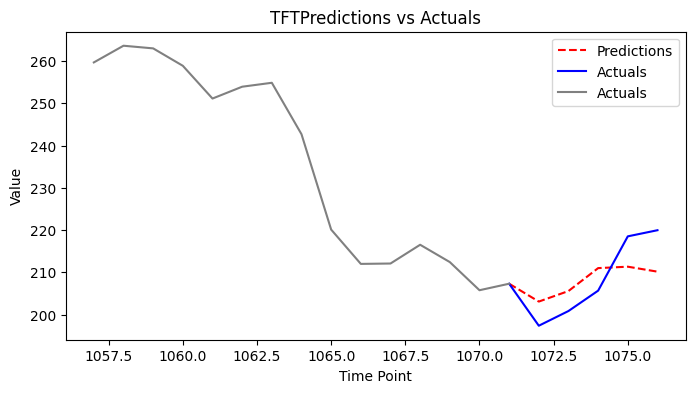

In [10]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

data1=used_data['Close']
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(predictions_np[1:], validation1[1:])

print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(predictions_np[1:], validation1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(predictions_np[1:], validation1[1:]))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(predictions_np[1:], validation1[1:])

print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")
plt.figure(figsize=(8, 4))


plt.plot(data1.index[-6:], predictions_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], validation1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-20:-5], data1[-20:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

1
Parameter containing:
tensor([1.2792e-05, 9.9999e-01, 1.9373e-06], requires_grad=True)


C:\Users\User\.conda\envs\project\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


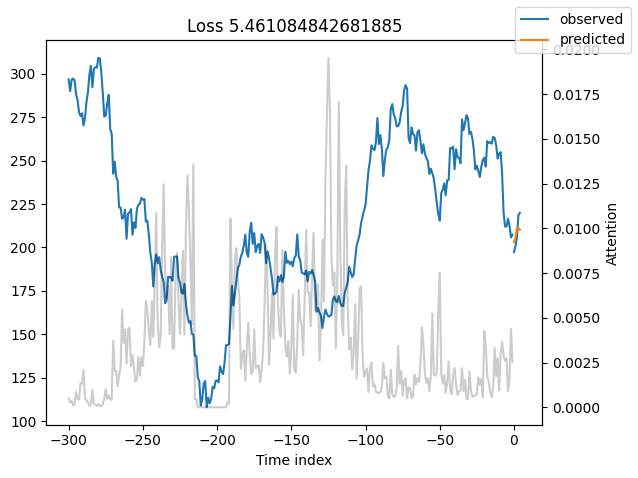

In [11]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
print(len(raw_predictions['encoder_lengths']) )
best_tft.plot_prediction(x, raw_predictions, idx=0, add_loss_to_title=True);

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x275 with 1 Axes>,
 'encoder_variables': <Figure size 700x475 with 1 Axes>,
 'decoder_variables': <Figure size 700x350 with 1 Axes>}

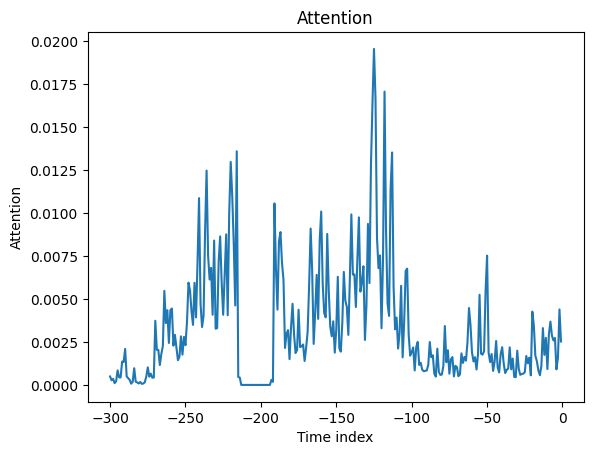

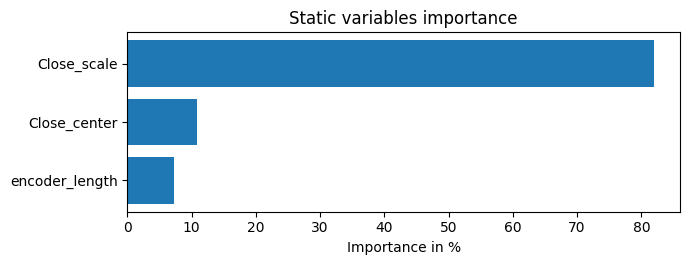

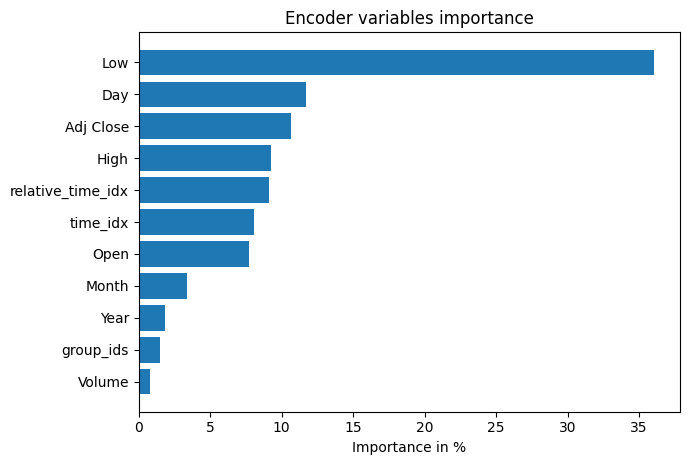

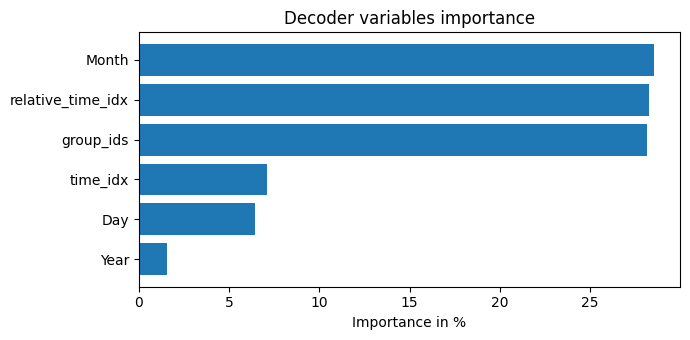

In [12]:
raw_predictions, x = best_tft.predict(val_dataloader, mode="raw", return_x=True)
interpretation = best_tft.interpret_output(raw_predictions, reduction="sum")
best_tft.plot_interpretation(interpretation)

In [13]:
torch.save(best_tft.state_dict(), 'TFT-model-weights.pth')

In [14]:
best_tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=0.1,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=dropout,
    hidden_continuous_size=hidden_continuous_size,
    loss = CustomQuantileLoss(quantiles=quantiles),
    log_interval=10,
    reduce_on_plateau_patience=4
)

best_tft.load_state_dict(torch.load('TFT-model-weights.pth'))


C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_lightning\utilities\parsing.py:261: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


<All keys matched successfully>

C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\lib\site-packages\pytorch_forecasting\models\base_model.py:1699: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  log_scale = scipy.stats.skew(values_actual) > 1.6
C:\Users\User\.conda\envs\project\

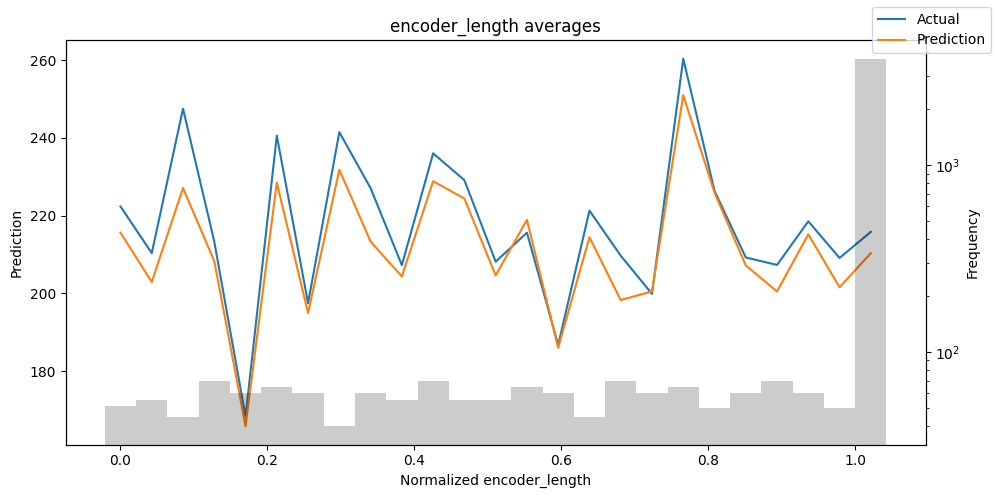

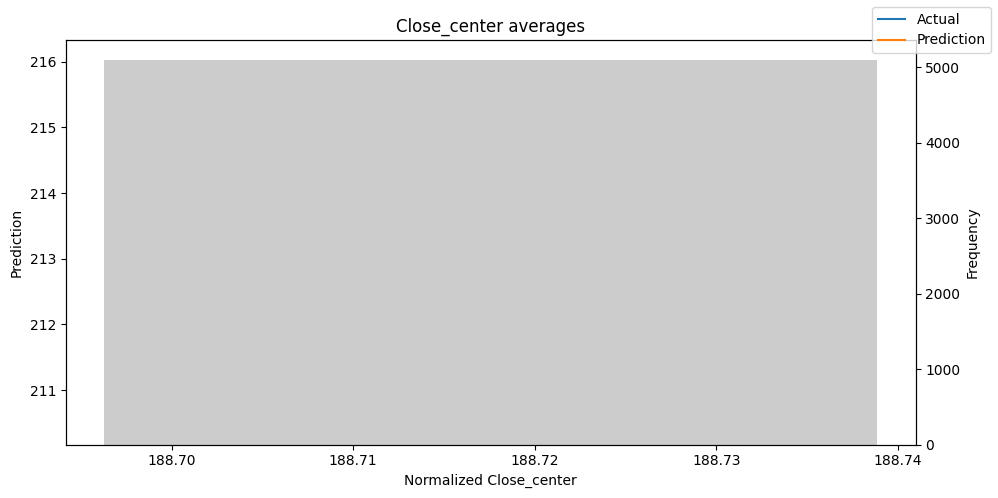

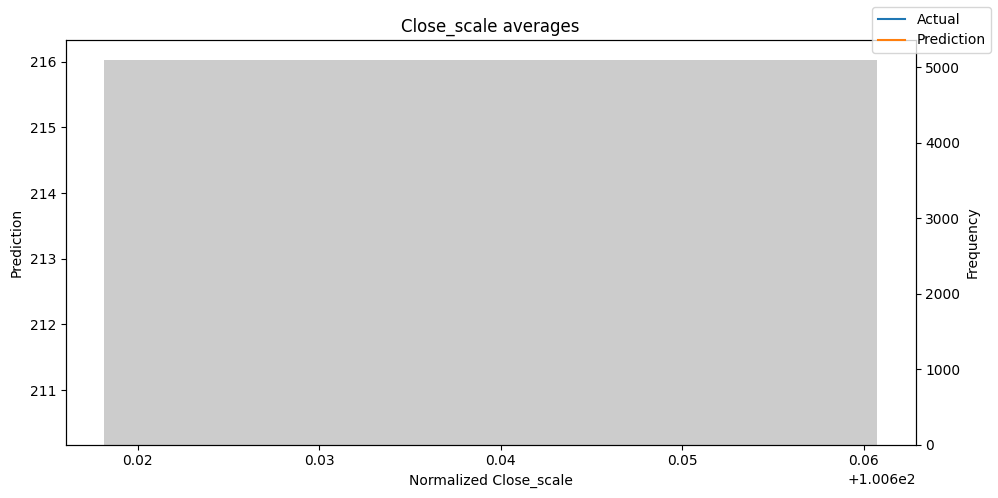

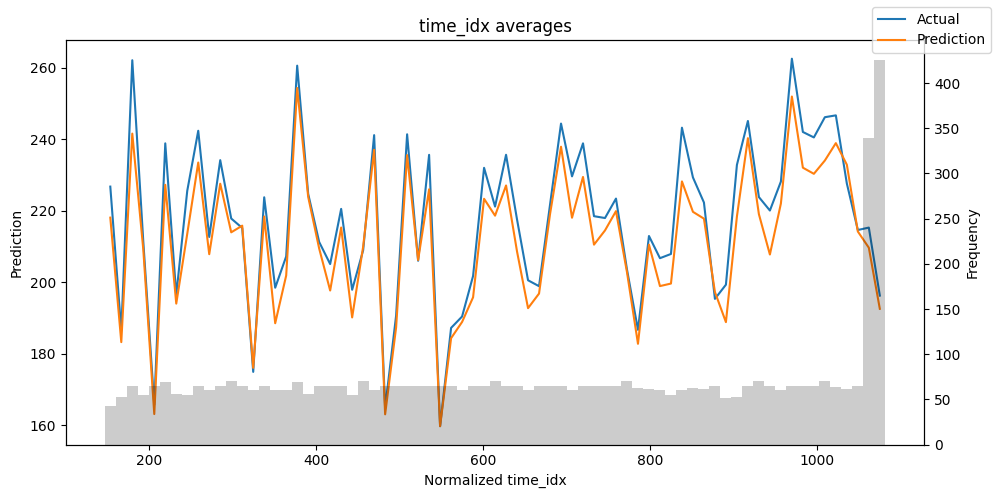

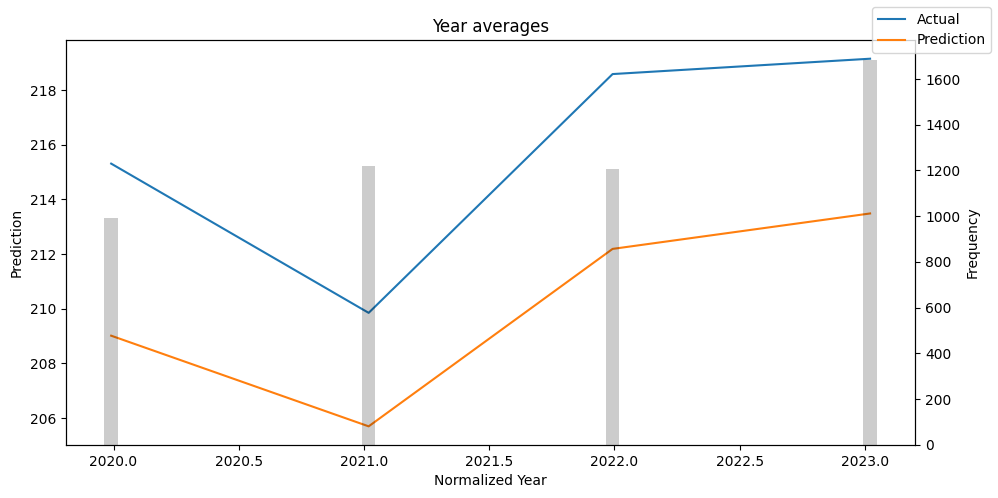

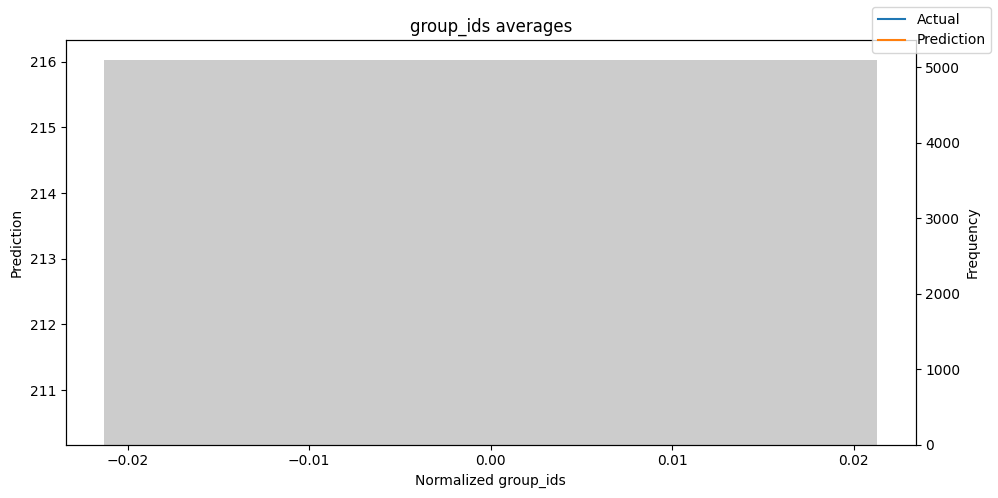

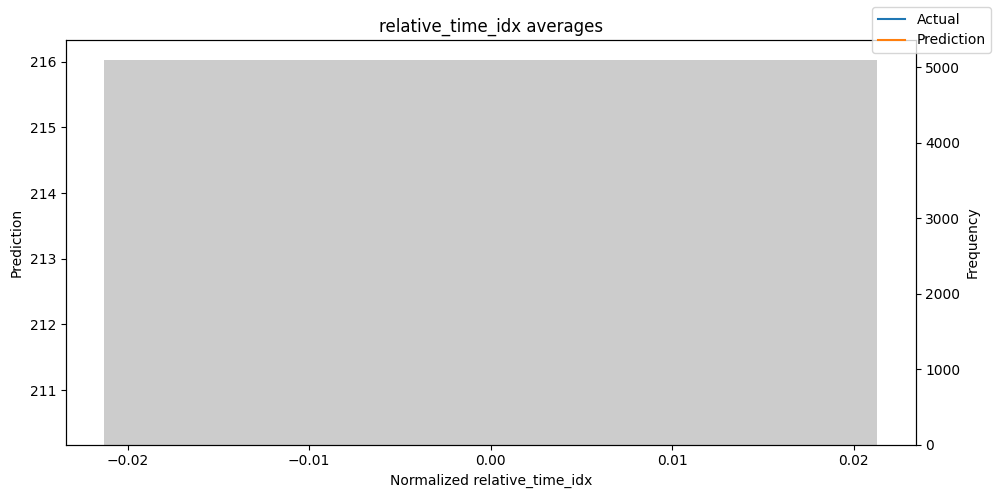

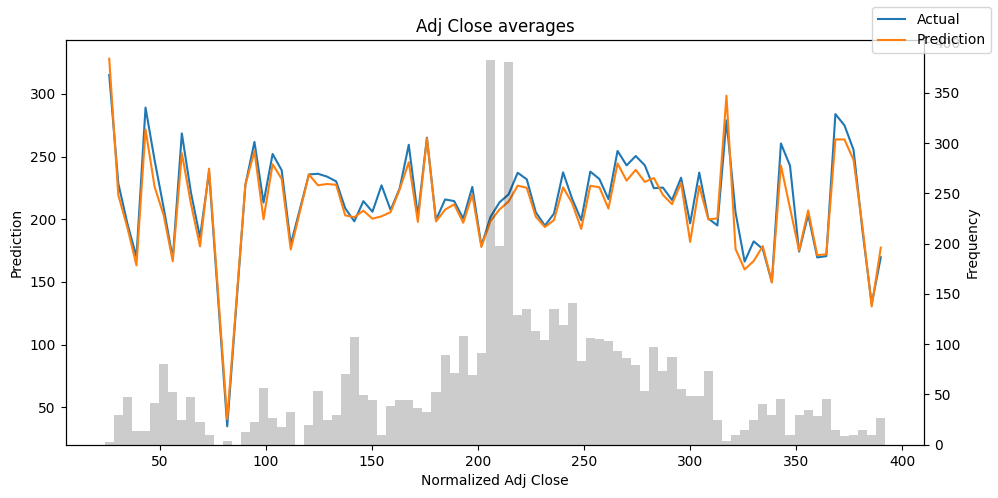

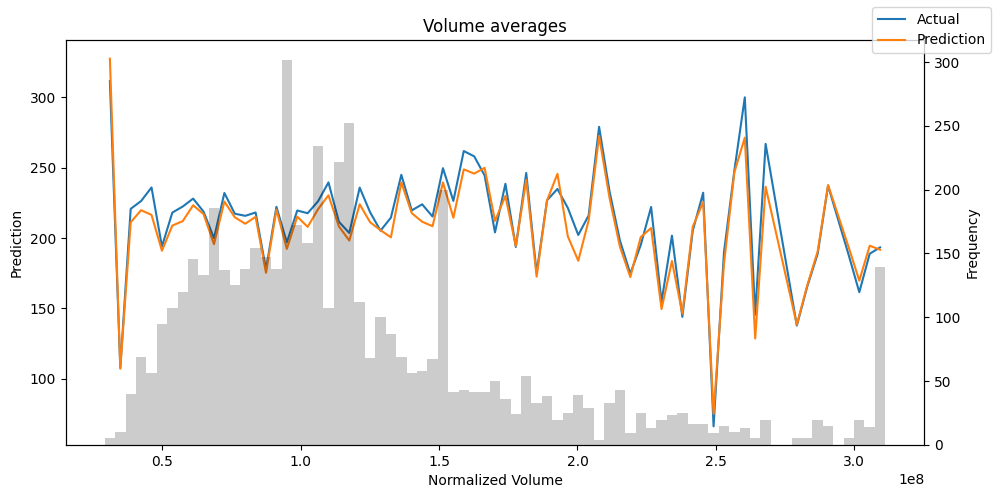

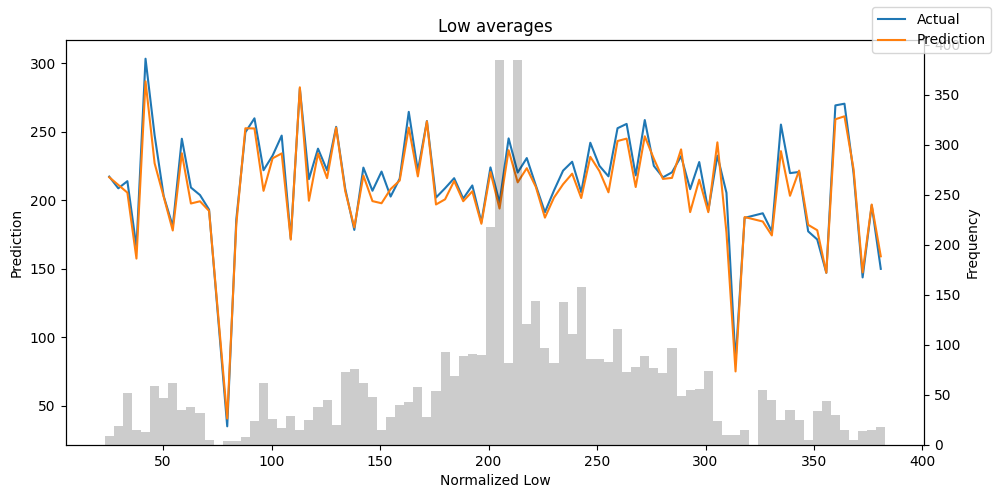

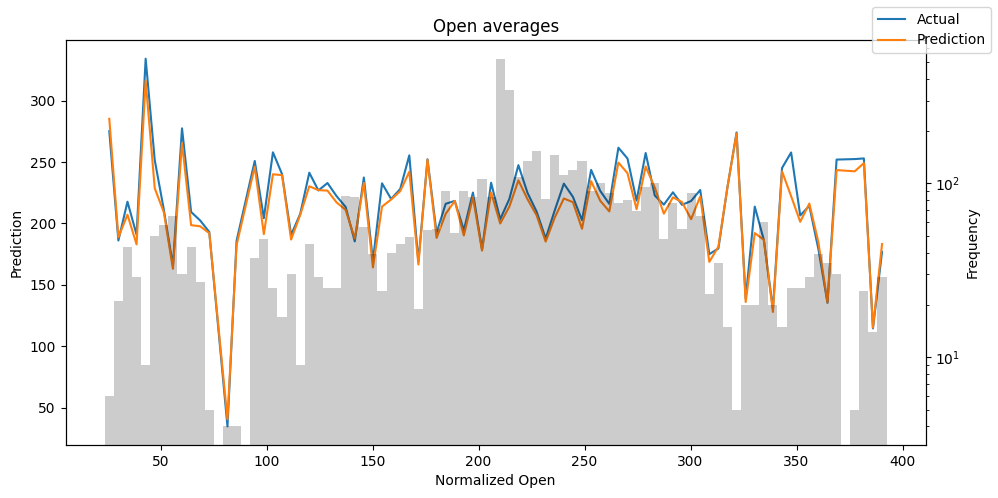

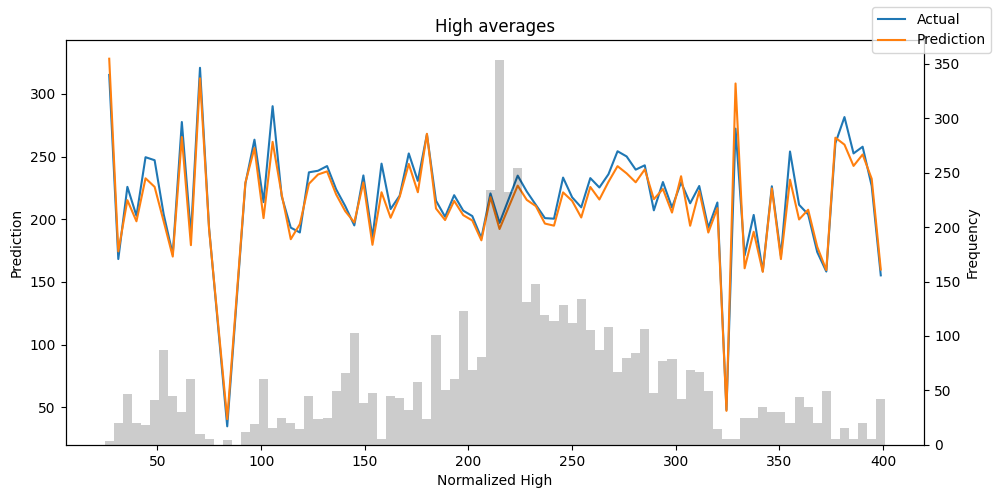

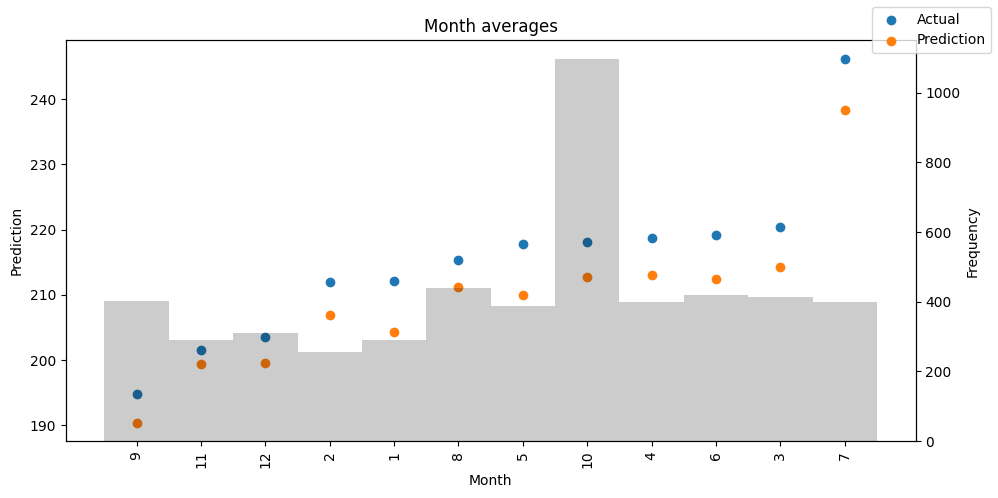

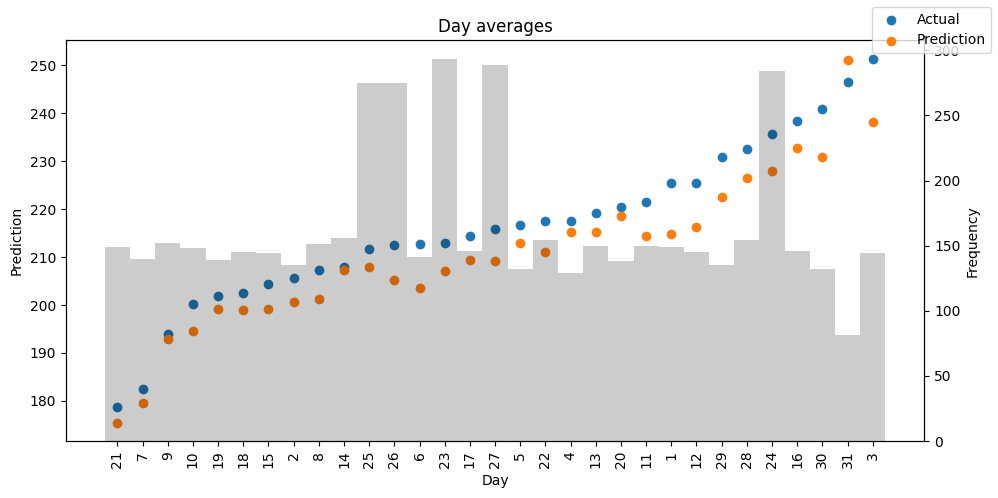

In [15]:

predictions, x = best_tft.predict(train_dataloader, return_x=True,)

predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions, normalize=True)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [16]:

test_actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])

test_results = best_tft.predict(test_dataloader)

mae = (test_actuals - test_results).abs().mean()

print(f'VAL-MAE: {mae}')


VAL-MAE: 9.853365898132324


In [17]:
import matplotlib.pyplot as plt
import torch

test_results_np = test_results.numpy()
test_actuals_np = test_actuals.numpy()
test_data1=test_data['Close'].tolist()

data1 = data['Close']
last_historical_point = data1.iloc[-6]
forecast_predictions = test_results_np[0]
forecast_actuals = test_data1
print(forecast_actuals)

[219.270004, 222.179993, 222.110001, 209.979996, 214.649994]


6 : 6 

[212.96432, 210.11874, 206.45288, 205.99367, 203.39354] 
 [219.270004, 222.179993, 222.110001, 209.979996, 214.649994]
Mean Absolute Error: 9.85336625234375
Mean Absolute Percentage Error: 4.750895742835489%
Root Mean Squared Error: 10.704945706632515
Mean Absolute Error: 9.85336625234375
Spearman's rho (ρ): 0.6
Spearman's p_value: 0.28475697986529375


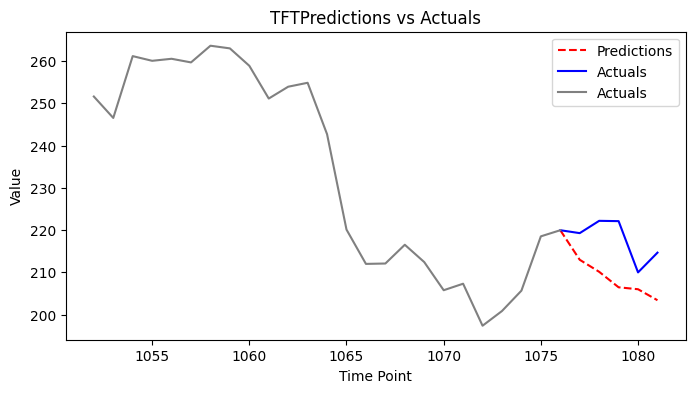

In [18]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_results_np = [last_historical_point] + list(forecast_predictions)
test_data1 = [last_historical_point] + list(forecast_actuals)

print(len(test_results_np),':',len(test_data1),'\n')
print(test_results_np[1:],'\n', test_data1[1:])

from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(test_results_np[1:], test_data1[1:])

print(f'Mean Absolute Error: {mae}')
mape = mean_absolute_percentage_error(test_results_np[1:], test_data1[1:])
print(f'Mean Absolute Percentage Error: {mape}%')

rmse = np.sqrt(mean_squared_error(test_results_np[1:], test_data1[1:]))
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')

from scipy.stats import spearmanr
corr, p_value = spearmanr(test_results_np[1:], test_data1[1:])

print(f"Spearman's rho (ρ): {corr}")
print(f"Spearman's p_value: {p_value}")

plt.figure(figsize=(8, 4))


plt.plot(data1.index[-6:], test_results_np, label='Predictions', marker='', linestyle='--', color='red')
plt.plot(data1.index[-6:], test_data1, label='Actuals', marker='', linestyle='-', color='blue')
plt.plot(data1.index[-30:-5], data1[-30:-5], label='Actuals', marker='', linestyle='-', color='grey')


plt.title('TFTPredictions vs Actuals')
plt.xlabel('Time Point')
plt.ylabel('Value')
plt.legend()
plt.show()

1
tensor([ 0.5730,  8.2111, 20.0000])
[tensor(0.5730), tensor(8.2111), tensor(20.0000)]
Parameter containing:
tensor([1.2792e-05, 9.9999e-01, 1.9373e-06], requires_grad=True)


C:\Users\User\.conda\envs\project\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `SpearmanCorrcoef` will save all targets and predictions in the buffer. For large datasets, this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


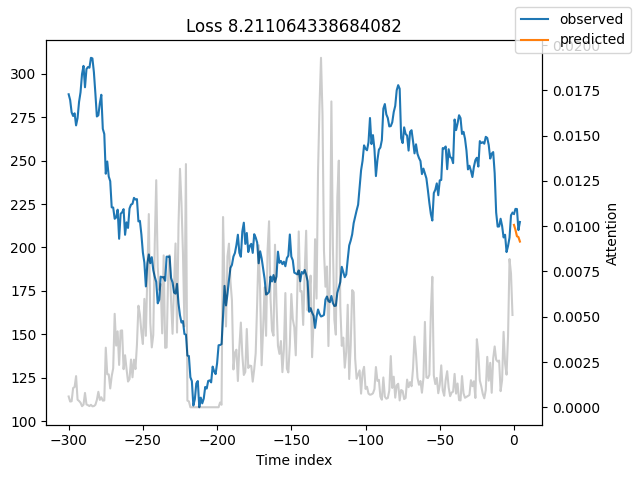

In [19]:
test_raw_predictions, test_x = best_tft.predict(test_dataloader, mode="raw", return_x=True)
print(len(test_raw_predictions['encoder_lengths']))
best_tft.plot_prediction(test_x, test_raw_predictions, idx=0, add_loss_to_title=True);